Checking FastAI

In [1]:
import numpy as np
import pandas as pd
import os
#print(os.listdir("/kaggle/input/tgs-salt-identification-challenge"))
#os.getcwd()

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
torch.cuda.set_device(0)

In [3]:
path = '/home/vishy/Desktop/Kaggle/TGS/Data/'
subpath = '/home/vishy/Desktop/Kaggle/TGS/Submissions/'

In [4]:
PATH = Path('/kaggle/input/tgs-salt-identification-challenge/')

In [5]:
PATH

PosixPath('/kaggle/input/tgs-salt-identification-challenge')

In [6]:
MASKS_FN = path+'train.csv'
TRAIN_DN = Path(path+'train/images/')
MASKS_DN = Path(path+'train/masks/')
TEST = Path(path+'test/images/')

PATH = Path('/home/vishy/Desktop/Kaggle/TGS/Data/')
PATH128 = Path('/tmp/128/')
TMP = Path('/tmp/')
MODEL = Path('/tmp/model/')
# PRETRAINED = Path('/kaggle/input/is-there-salt-resnet34/model/resnet34_issalt.h5')
seg = pd.read_csv(PATH/MASKS_FN).set_index('id')
seg.head()

sz = 128
bs = 16
nw = 4

In [7]:
train_names_png = [TRAIN_DN/f for f in os.listdir(PATH/TRAIN_DN)]
train_names = list(seg.index.values)
masks_names_png = [MASKS_DN/f for f in os.listdir(PATH/MASKS_DN)]
test_names_png = [TEST/f for f in os.listdir(PATH/TEST)]

In [8]:
train_names_png[0], masks_names_png[0], test_names_png[0]

(PosixPath('/home/vishy/Desktop/Kaggle/TGS/Data/train/images/7524d9b7bf.png'),
 PosixPath('/home/vishy/Desktop/Kaggle/TGS/Data/train/masks/7524d9b7bf.png'),
 PosixPath('/home/vishy/Desktop/Kaggle/TGS/Data/test/images/8cd406ddbd.png'))

In [9]:
TMP.mkdir(exist_ok=True)
PATH128.mkdir(exist_ok=True)
(PATH128/'train').mkdir(exist_ok=True)
(PATH128/'test').mkdir(exist_ok=True)
(PATH128/MASKS_DN).mkdir(exist_ok=True)
(PATH128/TRAIN_DN).mkdir(exist_ok=True)
(PATH128/TEST).mkdir(exist_ok=True)

In [10]:
def resize_mask(fn):
    Image.open(PATH/fn).resize((128,128)).save(PATH128/fn)

In [11]:
with ThreadPoolExecutor(4) as e: e.map(resize_mask, train_names_png)

In [12]:
with ThreadPoolExecutor(4) as e: e.map(resize_mask, masks_names_png)

In [13]:
with ThreadPoolExecutor(4) as e: e.map(resize_mask, test_names_png)

In [14]:
PATH = PATH128 #just for sanity

In [15]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [16]:
im, mk = Image.open(PATH/train_names_png[0]), Image.open(PATH/masks_names_png[0])

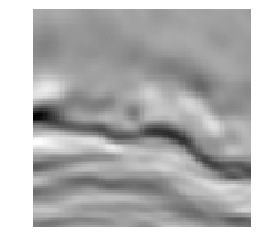

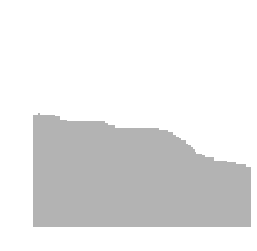

In [17]:
ax = show_img(im);
show_img(mk, alpha=0.3);

In [18]:
class CustomDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
        
    def get_x(self, i): 
        return open_image(os.path.join(self.path,self.fnames[i]))
    def get_y(self, i): 
        return open_image(os.path.join(self.path,self.y[i]))
    def get_c(self): return 0

In [19]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

In [20]:
x_names = [f'{x}.png' for x in train_names]
x_names_path = np.array([str(TRAIN_DN/x) for x in x_names])
y_names = [x for x in x_names]
y_names_path = np.array([str(MASKS_DN/x) for x in x_names])

In [21]:
im = open_image(str(PATH/y_names_path[1]))

In [22]:
# val_idxs = list(range(200))
val_idxs=list(range(0,200))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names_path, y_names_path)
test_x = np.array(test_names_png)

In [23]:
trn_x, trn_y, test_x

(array(['/home/vishy/Desktop/Kaggle/TGS/Data/train/images/3edc3edf92.png',
        '/home/vishy/Desktop/Kaggle/TGS/Data/train/images/86c1109730.png',
        '/home/vishy/Desktop/Kaggle/TGS/Data/train/images/b5bdff9392.png', ...,
        '/home/vishy/Desktop/Kaggle/TGS/Data/train/images/1306fcee4c.png',
        '/home/vishy/Desktop/Kaggle/TGS/Data/train/images/48d81e93d9.png',
        '/home/vishy/Desktop/Kaggle/TGS/Data/train/images/edf1e6ac00.png'], dtype='<U63'),
 array(['/home/vishy/Desktop/Kaggle/TGS/Data/train/masks/3edc3edf92.png',
        '/home/vishy/Desktop/Kaggle/TGS/Data/train/masks/86c1109730.png',
        '/home/vishy/Desktop/Kaggle/TGS/Data/train/masks/b5bdff9392.png', ...,
        '/home/vishy/Desktop/Kaggle/TGS/Data/train/masks/1306fcee4c.png',
        '/home/vishy/Desktop/Kaggle/TGS/Data/train/masks/48d81e93d9.png',
        '/home/vishy/Desktop/Kaggle/TGS/Data/train/masks/edf1e6ac00.png'], dtype='<U62'),
 array([PosixPath('/home/vishy/Desktop/Kaggle/TGS/Data/test/imag

In [24]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
             RandomFlip(tfm_y=TfmType.CLASS),
             RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]
#aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS)]

In [25]:
tfms = tfms_from_model(resnet34, sz=128, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(CustomDataset, (trn_x,trn_y), (val_x,val_y), tfms, (test_x, test_x), path=PATH)
md = ImageData(PATH, datasets, bs=bs, num_workers=nw, classes=None)
denorm = md.trn_ds.denorm

In [26]:
x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16, 128, 128]))

# Resnet18 - UNET

In [27]:
from fastai.models.unet import *

In [28]:
def get_encoder(f, cut):
    base_model = (cut_model(f(True), cut))
    return nn.Sequential(*base_model)

In [29]:
# Wrap everything nicely
class UpsampleModel():
    def __init__(self, model, cut_lr, name='upsample'):
        self.model,self.name, self.cut_lr = model, name, cut_lr

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.encoder), [self.cut_lr]))
        return lgs + [children(self.model)[1:]]

In [30]:
class DynamicUnet2(nn.Module):
    """
    A dynamic implementation of Unet architecture, because calculating connections
    and channels suck!. When an encoder is passed, this network will
    automatically construct a decoder after the first single forward pass for any
    given encoder architecture.

    Decoder part is heavily based on the original Unet paper:
    https://arxiv.org/abs/1505.04597.

    Inputs:
        encoder(nn.Module): Preferably a pretrained model, such as VGG or ResNet
        last (bool): Whether to concat only last activation just before a size change
        n_classes (int): Number of classes to output in final step of decoder

    Important Note: If architecture directly reduces the dimension of an image as soon as the
    first forward pass then output size will not be same as the input size, e.g. ResNet.
    In order to resolve this problem architecture will add an additional extra conv transpose
    layer. Also, currently Dynamic Unet expects size change to be H,W -> H/2, W/2. This is
    not a problem for state-of-the-art architectures as they follow this pattern but it should
    be changed for custom encoders that might have a different size decay.
    """

    def __init__(self, encoder, last=True, n_classes=3):
        super().__init__()
        self.encoder = encoder
        self.n_children = len(list(encoder.children()))
        self.sfs = [SaveFeatures(encoder[i]) for i in range(self.n_children)]
        self.last = last
        self.n_classes = n_classes

    def forward(self, x):
        dtype = x.data.type()

        # get imsize
        imsize = x.size()[-2:]

        # encoder output
        x = F.relu(self.encoder(x))

        # initialize sfs_idxs, sfs_szs, middle_in_c and middle_conv only once
        if not hasattr(self, 'middle_conv'):
            self.sfs_szs = [sfs_feats.features.size() for sfs_feats in self.sfs]
            self.sfs_idxs = get_sfs_idxs(self.sfs, self.last)
            middle_in_c = self.sfs_szs[-1][1]
            middle_conv = nn.Sequential(*conv_bn_relu(middle_in_c, middle_in_c * 2, 3, 1, 1),
                                        *conv_bn_relu(middle_in_c * 2, middle_in_c, 3, 1, 1))
            self.middle_conv = middle_conv.type(dtype)

        # middle conv
        x = self.middle_conv(x)

        # initialize upmodel, extra_block and 1x1 final conv
        if not hasattr(self, 'upmodel'):
            x_copy = Variable(x.data, requires_grad=False)
            upmodel = []
            for idx in self.sfs_idxs[::-1]:
                up_in_c, x_in_c = int(x_copy.size()[1]), int(self.sfs_szs[idx][1])
                unet_block = UnetBlock(up_in_c, x_in_c).type(dtype)
                upmodel.append(unet_block)
                x_copy = unet_block(x_copy, self.sfs[idx].features)
                self.upmodel = nn.Sequential(*upmodel)

            if imsize != self.sfs_szs[0][-2:]:
                extra_in_c = self.upmodel[-1].conv2.out_channels
                self.extra_block = nn.ConvTranspose2d(extra_in_c, extra_in_c, 2, 2).type(dtype)

            final_in_c = self.upmodel[-1].conv2.out_channels
            self.final_conv = nn.Conv2d(final_in_c, self.n_classes, 1).type(dtype)

        # run upsample
        for block, idx in zip(self.upmodel, self.sfs_idxs[::-1]):
            x = block(x, self.sfs[idx].features)
        if hasattr(self, 'extra_block'):
            x = self.extra_block(x)

        out = self.final_conv(x)
        if self.n_classes == 1:
            out = out.squeeze(1)
        return out

In [33]:
#f = resnet18 #0.7
# f = resnet34 #0.737
f = resnet152 #0.747
cut,lr_cut = model_meta[f]
cut,lr_cut

(8, 6)

In [34]:
encoder= get_encoder(f, lr_cut)
# m_base = get_base()
m = DynamicUnet2(encoder, n_classes=1).cuda()
# m = to_gpu(Unet34(m_base))
# models = UnetModel(m)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/vishy/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [01:55<00:00, 2088586.58it/s]


In [35]:
inp = torch.ones(1, 3, 128, 128)
out = m(V(inp))
out.shape

torch.Size([1, 128, 128])

In [36]:
models = UpsampleModel(m,5)

In [37]:
learn = ConvLearner(md, models, tmp_name=TMP, models_name=MODEL)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice, IoU]

In [38]:
learn.freeze_to(1)

 72%|███████▏  | 171/238 [00:15<00:06, 10.92it/s, loss=1.64] 

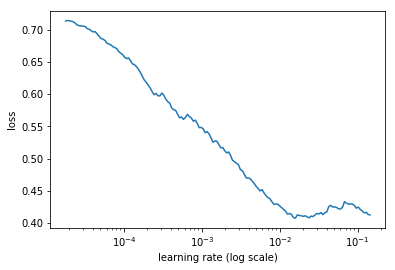

 72%|███████▏  | 171/238 [00:30<00:06, 10.92it/s, loss=1.64]

In [39]:
learn.lr_find()
learn.sched.plot()

In [40]:
lr=1e-3
wd=1e-4

lrs = np.array([lr/100,lr/100,lr/10])

In [41]:
learn.fit(lr,1,wds=wd,cycle_len=20,use_clr=(8,5))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.298829   0.233354   0.885242   0.746716   0.621451  
    1      0.237841   0.163349   0.937601   0.84207    0.744195  
    2      0.20879    0.182492   0.924169   0.818876   0.713752  
    3      0.214563   0.156428   0.942751   0.857631   0.768852  
    4      0.212778   0.167124   0.939196   0.84895    0.756331  
    5      0.188705   0.160749   0.935646   0.851337   0.755968  
    6      0.191342   0.167488   0.918459   0.809521   0.70324   
    7      0.17114    0.145915   0.943318   0.867395   0.779237  
    8      0.168796   0.127335   0.951321   0.88679    0.811739  
    9      0.173754   0.210439   0.935592   0.842624   0.742841  
    10     0.152692   0.120878   0.952644   0.876735   0.794645  
    11     0.173548   0.152982   0.949343   0.87174    0.78715   
    12     0.162242   0.140953   0.935282   0.859377   0.767293  
    13     0.150449   0.119544   0.954093   0.890533   0.814593  
    14   

[array([0.0998]), 0.9602606201171875, 0.902306568836941, 0.8337212600869427]

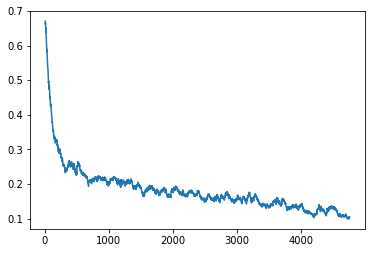

In [42]:
learn.sched.plot_loss()

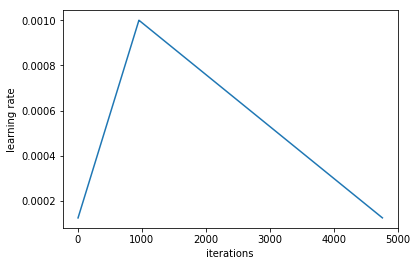

In [43]:
learn.sched.plot_lr()

In [44]:
learn.save('18unet1')

In [45]:
learn.load('18unet1')

In [46]:
learn.fit(lr,1,cycle_len=16,use_clr_beta=(10,10, 0.85, 0.9))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.101769   0.110612   0.957859   0.895691   0.823452  
    1      0.101947   0.117698   0.957781   0.897101   0.825316  
    2      0.12042    0.163319   0.938255   0.858064   0.763634  
    3      0.132192   0.130203   0.950906   0.887601   0.813367  
    4      0.142952   0.267194   0.906767   0.794428   0.665939  
    5      0.134094   0.129224   0.947585   0.876263   0.793795  
    6      0.141583   0.142726   0.947026   0.8776     0.791486  
    7      0.127569   0.21027    0.928986   0.840795   0.736883  
    8      0.124498   0.132703   0.942713   0.858352   0.770598  
    9      0.123757   0.118945   0.94948    0.86773    0.788972  
    10     0.10409    0.165942   0.936913   0.853903   0.758844  
    11     0.092532   0.130286   0.953708   0.885915   0.808893  
    12     0.079892   0.12217    0.951737   0.879841   0.79906   
    13     0.072997   0.127302   0.954121   0.884892   0.808709  
    14   

[array([0.13041]), 0.9561196899414063, 0.8910619403947913, 0.816435558796247]

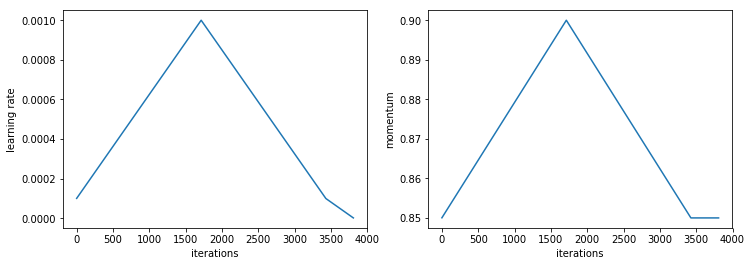

In [47]:
learn.sched.plot_lr()

In [48]:
learn.unfreeze()
learn.bn_freeze(True)

In [49]:
learn.fit(lrs/10, 1, wds=1e-7, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.051035   0.132224   0.95582    0.890384   0.815559  
    1      0.055348   0.132446   0.955808   0.890777   0.816079  
    2      0.054323   0.132391   0.955824   0.89023    0.815374  
    3      0.053428   0.133949   0.955977   0.890762   0.816128  
    4      0.053079   0.134157   0.955256   0.887545   0.811869  
    5      0.054238   0.134745   0.955937   0.890899   0.816318  
    6      0.06035    0.133901   0.95565    0.890389   0.815618  
    7      0.054335   0.133625   0.955761   0.890791   0.81614   
    8      0.056456   0.133658   0.955943   0.891062   0.816514  
    9      0.052207   0.133892   0.955872   0.890777   0.816164  


[array([0.13389]), 0.9558718872070312, 0.8907767228090087, 0.8161639051023875]

In [50]:
py,ay = learn.predict_with_targs()

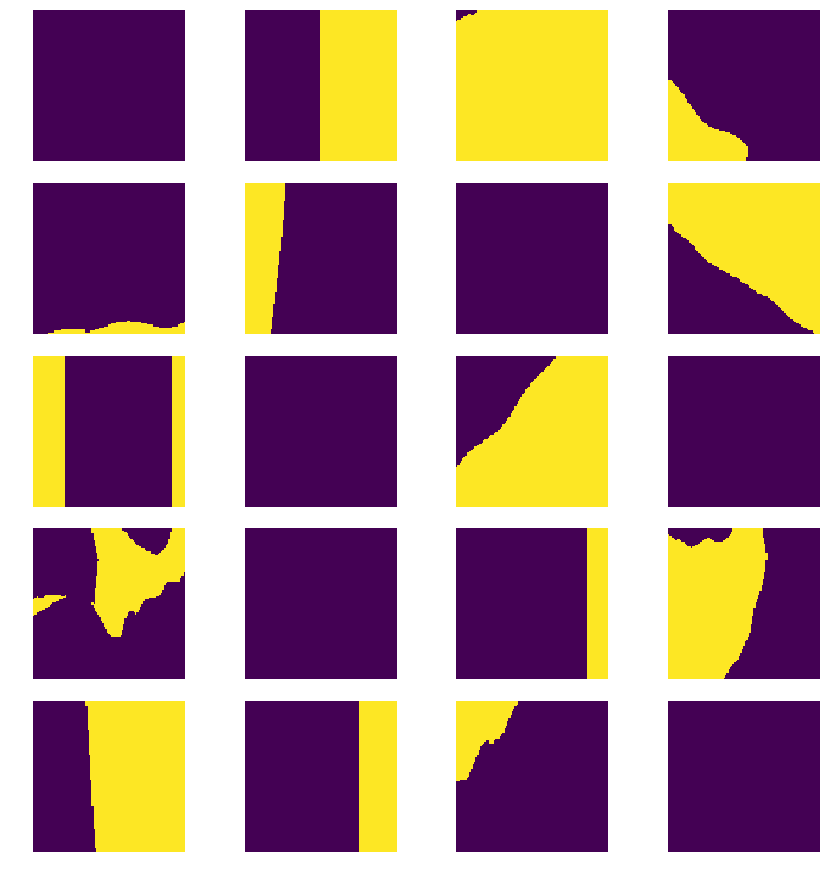

In [51]:
fig, axes = plt.subplots(5, 4, figsize=(12, 12))
for i,ax in enumerate(axes.flat):
    ax = show_img((ay[i]), ax=ax)
plt.tight_layout(pad=0.1)

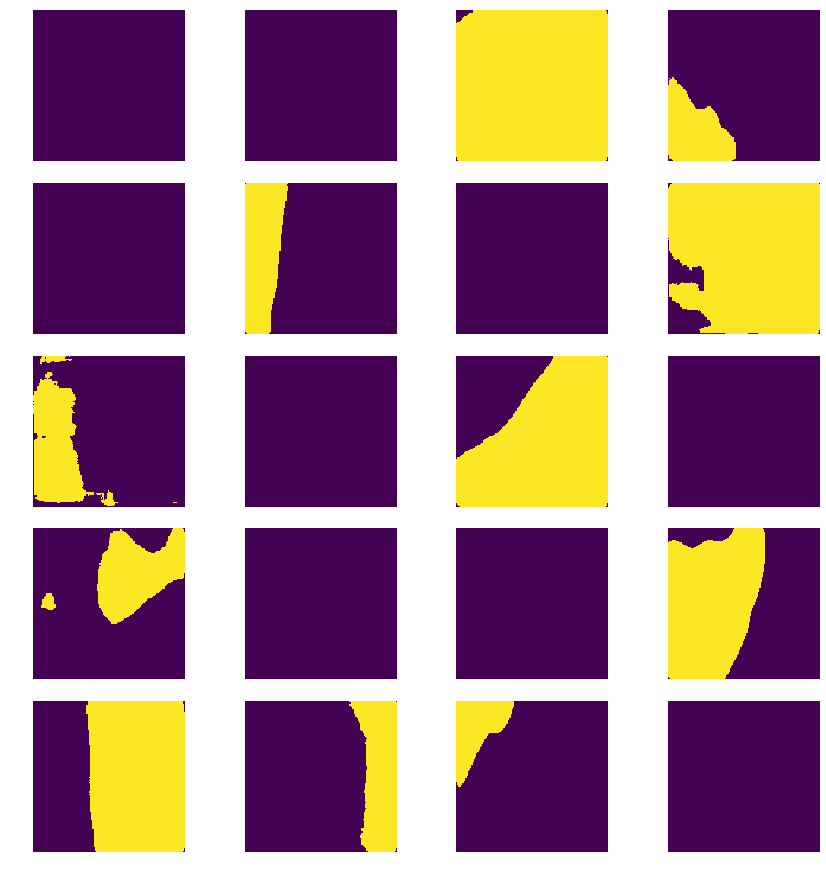

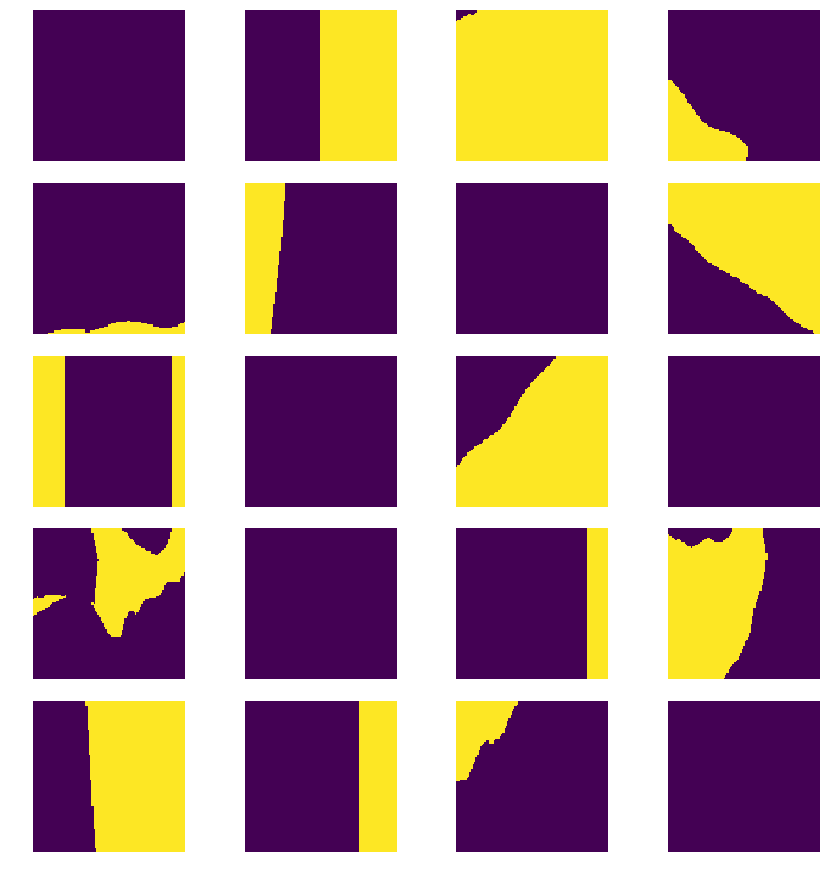

In [52]:
fig, axes = plt.subplots(5, 4, figsize=(12, 12))
for i,ax in enumerate(axes.flat):
    ax = show_img((py[i]>0), ax=ax)
plt.tight_layout(pad=0.1)

fig, axes = plt.subplots(5, 4, figsize=(12, 12))
for i,ax in enumerate(axes.flat):
    ax = show_img((ay[i]), ax=ax)
plt.tight_layout(pad=0.1)

# Predict

In [53]:
# Predict on Test data
out = learn.predict(is_test=True)
np.save('preds1',out)
out.shape

(18000, 128, 128)

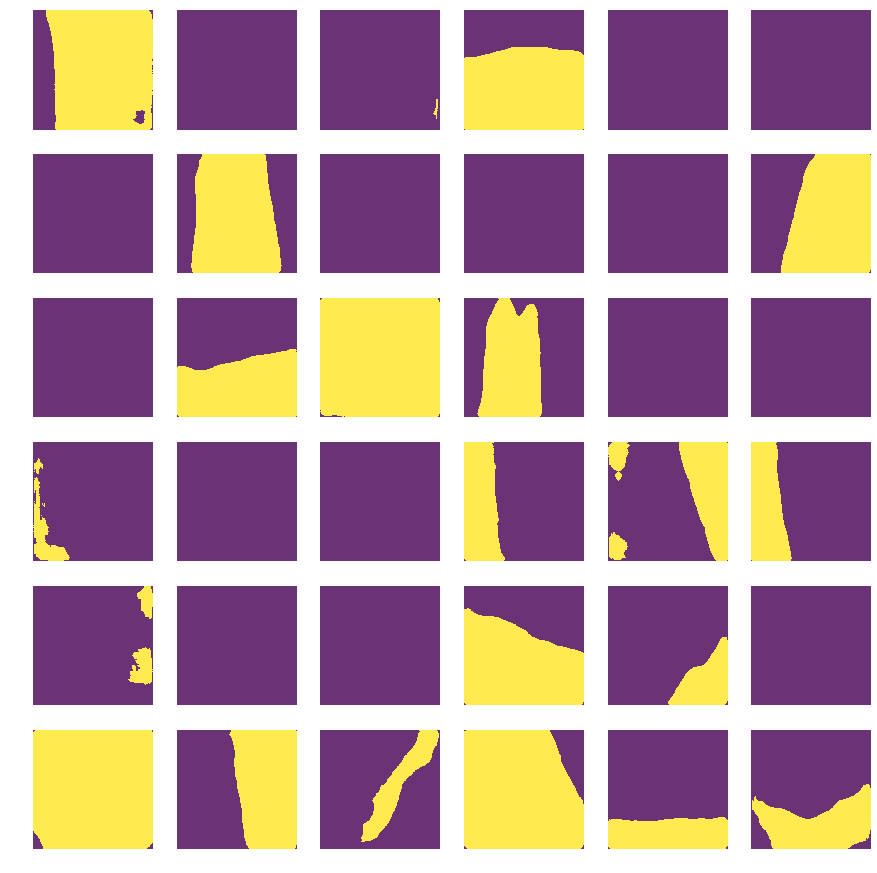

In [55]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
for i,ax in enumerate(axes.flat):
#     ax = show_img(Image.open(PATH/test_names_png[i]), ax=ax)
    show_img(out[i]>0, ax=ax, alpha=0.8)
plt.tight_layout(pad=0.1)

In [56]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order=F)
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [57]:
tmp_list = []
name_list = []
for i in range(18000):
    img = cv2.resize(out[i,:,:], dsize=(101,101), interpolation = cv2.INTER_CUBIC)
    tmp_list.append(rle_encode(img>0))
    name_list.append(test_names_png[i].name[0:-4])

/home/vishy/anaconda3/envs/npytorch/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  


In [58]:
sub = pd.DataFrame(list(zip(name_list, tmp_list)), columns = ['id', 'rle_mask'])

In [59]:
sub.head()

,id,rle_mask
0,8cd406ddbd,1112 7 1213 10 1314 13 1415 16 1516 22 1617 30...
1,4a4e33c15e,
2,a5079cb93c,9592 1 9782 3 9881 5 9973 17 10076 6
3,0f776d1a05,41 60 142 61 243 61 344 61 445 61 545 62 647 6...
4,b54e6cba44,


In [60]:
#sub.to_csv(subpath+'submission_v17.csv', index=False) #0.70
# sub.to_csv(subpath+'submission_v18.csv', index=False) #0.737
sub.to_csv(subpath+'submission_v18b.csv', index=False) #0.737

In [ ]:
#last version 1PM - 03/10/